# Customizing sampling strategy

The default strategy of flowMC looks like the following:

1. In training phase
    1. Sample with local sampler
    2. Train normalizing flow with the samples
    3. Sample with global sampler
2. Freeze the normalizing flow
3. In production phase
    1. Sample with local sampler
    2. Sample with global sampler


One of the major changes introduced in `flowMC` 0.4.0 is the ability to customize the sampling strategy. In this notebook, we will demonstrate how to build your own sampling strategy to sample a Normal distribution when the initialization is very off from the true distribution.

In [1]:
import jax
import jax.numpy as jnp
from flowMC.resource.local_kernel.Gaussian_random_walk import GaussianRandomWalk
from flowMC.resource.buffers import Buffer
from flowMC.resource.logPDF import LogPDF
from flowMC.strategy.optimization import AdamOptimization
from flowMC.strategy.take_steps import TakeSerialSteps
from flowMC.Sampler import Sampler
import numpy as np


def target_log_prob(x, data):
    return -jnp.sum(x**2) / 2

# Using only random walk Gaussian proposal

To begin with, let's consider a simple case where we only use random walk Gaussian proposal to sample from the target distribution. We need to initialize the resources, which includes the random walk Gaussian proposal and the buffers we wish to store the relevant information, as well as the strategy which is taking serial steps using the proposal and updating the buffers.

In [2]:
# Defining hyperparameters
n_chains = 5
n_dims = 2
rng_key = jax.random.PRNGKey(0)
n_steps = 200
step_size = 1

# Setting up resources

RWMCMC_sampler = GaussianRandomWalk(step_size=step_size)
positions = Buffer("positions", (n_chains, n_steps, n_dims), 1)
log_prob = Buffer("log_prob", (n_chains, n_steps), 1)
acceptance = Buffer("acceptance", (n_chains, n_steps), 1)
resource = {
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "RWMCMC": RWMCMC_sampler,
    "logpdf": LogPDF(target_log_prob, n_dims=n_dims),
}

# Defining strategy

strategy = {
    "take_serial_step": TakeSerialSteps(
        logpdf_name="logpdf",
        kernel_name="RWMCMC",
        buffer_names=["positions", "log_prob", "acceptance"],
        n_steps=n_steps,
    )
}

# Initializing sampler

nf_sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resource,
    strategies=strategy,
    strategy_order=["take_serial_step"],
)

Resources and strategies provided. Ignoring resource strategy bundles.


Now let's consider the scenario where the initialization is very off from the true distribution, so the sampler may spend a lot of time traveling from the tail of the distribution to the most probable set. To do this, instead of initializing with a unit gaussian centers at 0, we initialize with a gaussian that is centered at 100


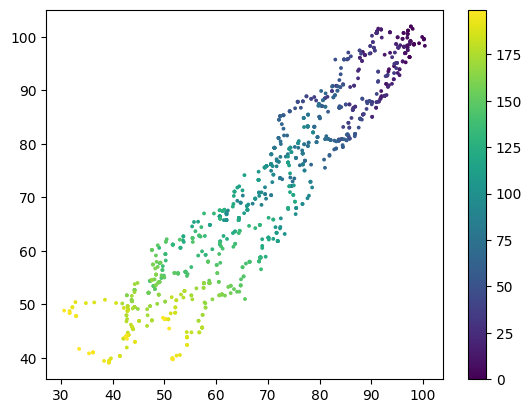

In [3]:
import matplotlib.pyplot as plt

rng_key, subkey = jax.random.split(rng_key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dims)) + 100

nf_sampler.sample(initial_position, {})

output_chains = nf_sampler.resources["positions"].data.reshape(-1, n_dims)
plt.figure()
plt.scatter(
    output_chains[:, 0],
    output_chains[:, 1],
    c=np.repeat(np.arange(output_chains.shape[0] // 5)[None], 5, axis=0).flatten(),
    s=3,
)
plt.colorbar()

We can see the plot shows the samples started from the initialization of 100, and all of the steps are just random walk toward a Normal distribution center at 1. This corresponds to a chains that have not "burned in" yet.

Now instead of only running the proposal kernel, we add an optimization phase before the sampling to move the initialization closer to the true distribution.

Resources and strategies provided. Ignoring resource strategy bundles.
Using Adam optimization


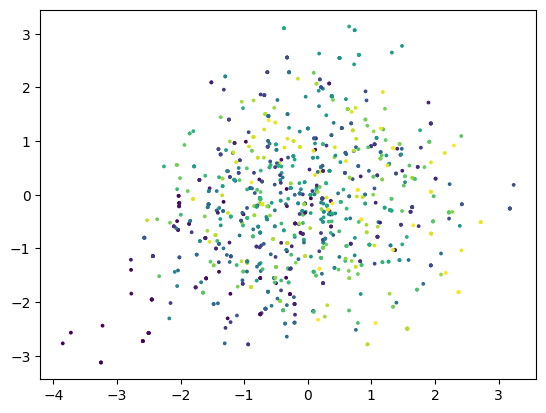

In [4]:
# Defining hyperparameters for optimization
n_opt_steps = 50
learning_rate = 3
noise_level = 0.1
adam_optimizer = AdamOptimization(
    target_log_prob,
    n_steps=n_opt_steps,
    learning_rate=learning_rate,
    noise_level=noise_level,
)

# Constructing the resources again.
positions = Buffer("positions", (n_chains, n_steps, n_dims), 1)
log_prob = Buffer("log_prob", (n_chains, n_steps), 1)
acceptance = Buffer("acceptance", (n_chains, n_steps), 1)
resource = {
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "RWMCMC": RWMCMC_sampler,
    "logpdf": LogPDF(target_log_prob, n_dims=n_dims),
}

strategy = TakeSerialSteps(
    logpdf_name="logpdf",
    kernel_name="RWMCMC",
    buffer_names=["positions", "log_prob", "acceptance"],
    n_steps=n_steps,
)

# Prepending the optimization strategy to the list of strategies

nf_sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resource,
    strategies={
        "take_serial_step": strategy,
        "optimize": adam_optimizer,
    },
    strategy_order=["optimize", "take_serial_step"],
)

nf_sampler.sample(initial_position, {})

output_chains = nf_sampler.resources["positions"].data.reshape(-1, n_dims)
plt.figure()
plt.scatter(
    output_chains[:, 0],
    output_chains[:, 1],
    c=np.repeat(np.arange(output_chains.shape[0] // 5)[None], 5, axis=0).flatten(),
    s=3,
)

Now we can see the sampling result is much close to the target distribution. It overshoots a little bit since we chose a fairly large step size for the optimization phase. One can tune the step size to get a better result.